# BAT.jl: Background + Signal Analysis 

In [1]:
using Random, LinearAlgebra, Statistics, Distributions, StatsBase
using EponymTuples
using BAT, IntervalSets
using ValueShapes
using Plots
pyplot()
ENV["JULIA_INFO"] = "BAT"

"BAT"

## Generate data [to be deleted]

In [2]:
bins=0:0.5:30
N_background = 1500
λ = 10

data_background = rand(Truncated(Exponential(λ), 0, 30), 1500)
hist_background = append!(Histogram(bins), data_background);

In [3]:
N_signal = 100
N_s_background = 1400
μ_true = 15.0
σ_true = 0.7

data_signal =  vcat(
    rand(Truncated(Exponential(λ), 0, 30), N_s_background),
    rand(Normal( μ_true, σ_true), N_signal)
)

hist_signal = append!(Histogram(bins), data_signal);

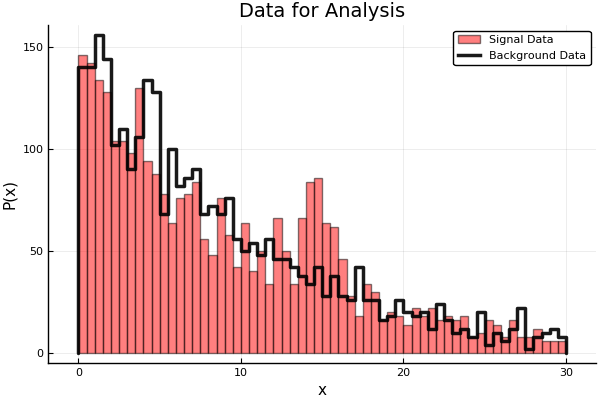

In [4]:
plot(normalize(hist_signal, mode=:density), alpha=0.5, color=:red, label="Signal Data")
plot!(normalize(hist_background, mode=:density),  seriestype = :steps, lw=2.5, alpha=0.9, color=:black, label="Background Data")
plot!(xlabel = "x", ylabel="P(x)", title="Data for Analysis")


## Define model functions: 

In [5]:
function background_model_1(@eponymargs(A), x::Real)
    A[1] + A[2]*x + A[3]*x^2
end

function background_model_2(@eponymargs(A), x::Real)
    A[1] + (1/A[2])*exp(-x/A[3])
end

function background_signal_model(@eponymargs(A, D, x_0, G), x::Real)
    A[1] + (1/A[2])*exp(-x/A[3]) + D[1]/((x - x_0[1])^2+G[1]^2)
end

background_signal_model (generic function with 1 method)

## Define likelihood function with Poisson noise: 

In [6]:
struct HistogramLikelihood{H<:Histogram,F<:Function} <: AbstractDensity
    histogram::H
    fitfunc::F
end

In [7]:
function BAT.density_logval(
    likelihood::HistogramLikelihood,
    params::Union{NamedTuple,AbstractVector{<:Real}}
)
    # Histogram counts for each bin as an array:
    counts = likelihood.histogram.weights

    # Histogram binning, has length (length(counts) + 1):
    binning = likelihood.histogram.edges[1]
    
    log_likelihood::Float64 = 0.0
    for i in eachindex(counts)
        bin_left, bin_right = binning[i], binning[i+1]
        bin_width = bin_right - bin_left
        bin_center = (bin_right + bin_left) / 2
        observed_counts = counts[i]
        expected_counts = bin_width * likelihood.fitfunc(params, bin_center)
        if expected_counts > 0 
            log_likelihood += logpdf(Poisson(expected_counts), observed_counts)
        else
           log_likelihood += -Inf
        end 
    end

    return log_likelihood
end

In [8]:
algorithm = MetropolisHastings(MvTDistProposalSpec(1.0))
rngseed = BAT.Philox4xSeed()
nsamples = 5*10^5
max_nsteps = 5*10^5
nchains = 8

tuner_config = ProposalCovTunerConfig(
    λ = 0.5,
    α = 0.15..0.35,
    β = 1.5,
    c = 1e-4..1e2
)

convergence_test = BGConvergence(
    threshold = 1.1,
    corrected = false
)

init_strategy = MCMCInitStrategy(
    ninit_tries_per_chain = 8..128,
    max_nsamples_pretune = 25,
    max_nsteps_pretune = 250,
    max_time_pretune = Inf
)

burnin_strategy = MCMCBurninStrategy(
    max_nsamples_per_cycle = 10000,
    max_nsteps_per_cycle = 20000,
    max_time_per_cycle = Inf,
    max_ncycles = 100
);

## Background model #1:  

In [9]:
likelihood_bm1 = HistogramLikelihood(hist_background, background_model_1);

In [10]:
prior_bm1 = NamedPrior(
    A = [-1000.0 .. 1000.0, -1000.0 .. 1000.0, -1000.0 .. 1000.0],
);

In [11]:
parshapes_bm1 = VarShapes(prior_bm1)
posterior_bm1 = PosteriorDensity(likelihood_bm1, prior_bm1);
chainspec_bm1 = MCMCSpec(algorithm, posterior_bm1, rngseed);

In [12]:
samples_bm1, sampleids_bm1, stats_bm1, chains_bm1 = rand(
    chainspec_bm1,
    nsamples,
    nchains,
    tuner_config = tuner_config,
    convergence_test = convergence_test,
    init_strategy = init_strategy,
    burnin_strategy = burnin_strategy,
    max_nsteps = max_nsteps,
    max_time = Inf,
    granularity = 1
);

┌ Info: Trying to generate 8 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:160
┌ Info: Selected 8 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:269
┌ Info: Begin tuning of 8 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:52
┌ Info: MCMC Tuning cycle 1 finished, 8 chains, 0 tuned, 0 converged.
└ @ BAT /home/iwsatlas1/vhafych/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:84
┌ Info: MCMC Tuning cycle 2 finished, 8 chains, 0 tuned, 0 converged.
└ @ BAT /home/iwsatlas1/vhafych/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:84
┌ Info: MCMC Tuning cycle 3 finished, 8 chains, 0 tuned, 0 converged.
└ @ BAT /home/iwsatlas1/vhafych/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:84
┌ Info: MCMC Tuning cycle 4 finished, 8 chains, 0 tuned, 0 converged.
└ @ BAT /home/iwsatlas1/vhafych/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:84
┌ Info: MCM

In [13]:
println("Mode: $(stats_bm1.mode)")
println("Mean: $(stats_bm1.param_stats.mean)")
println("Covariance: $(stats_bm1.param_stats.cov)")

Mode: [142.09527444652693, -9.697328089235423, 0.177904772603914]
Mean: [142.3897809073695, -9.729793460029361, 0.17894895880263095]
Covariance: [25.80761707331964 -2.7364192247720376 0.0666380711291434; -2.736419224772037 0.3468431857443933 -0.00930131830630478; 0.06663807112914338 -0.00930131830630478 0.0002627719310709664]


In [14]:
mode_parms_bm1 = parshapes_bm1(stats_bm1.mode)

(A = [142.09527444652693, -9.697328089235423, 0.177904772603914],)

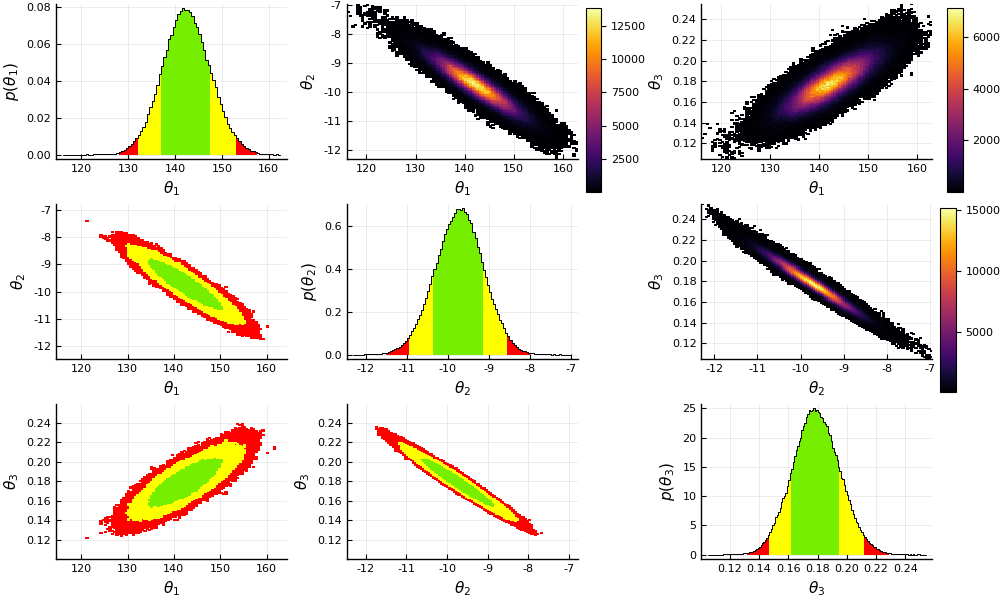

In [15]:
plot(samples_bm1)

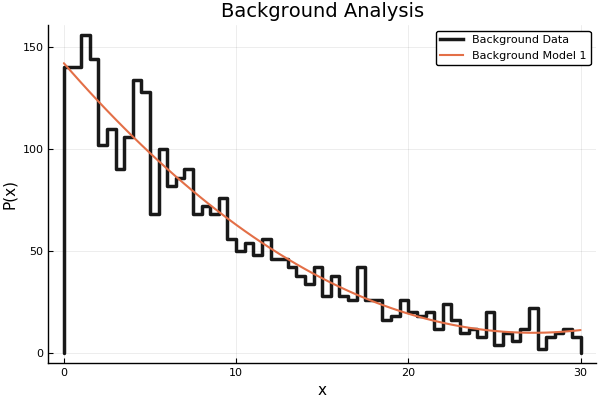

In [16]:
plot(normalize(hist_background, mode=:density),  seriestype = :steps, lw=2.5, alpha=0.9, color=:black, label="Background Data")
plot!(xlabel = "x", ylabel="P(x)", title="Background Analysis")

plot!(
    bins, x -> background_model_1(mode_parms_bm1, x),
    label = "Background Model 1", lw=1.5, color=2
)


In [17]:
data_bm1 = HMIData(samples_bm1)
        
hm_integrate!(data_bm1)

┌ Info: Harmonic Mean Integration started. Samples in dataset 1 / 2: 	511545 / 511545	Parameters:	3
└ @ BAT /home/iwsatlas1/vhafych/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:87
┌ Info: Data Whitening.
└ @ BAT /home/iwsatlas1/vhafych/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:100
┌ Info: Apply Whitening Transformation to Data Set 2
└ @ BAT /home/iwsatlas1/vhafych/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:109
┌ Info: Create Space Partitioning Tree
└ @ BAT /home/iwsatlas1/vhafych/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:121
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
┌ Info: Determine Hyperrectangle Starting Samples
└ @ BAT /home/iwsatlas1/vhafych/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:137
┌ Info: Determine Tolerances for Hyperrectangle Creation
└ @ BAT /home/iwsatlas1/vhafych/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.j

Parameters: 3	Total Samples: 1023090
Data Set 1: 19 Volumes
Data Set 2: 17 Volumes

Integral Estimate (cov. weighted result):
	 5.56288e-85  +-  4.55341e-87

Integral Estimate (analytic result):
	 5.57868e-85  +-  3.43303e-87


## Background model #2:  

In [18]:
likelihood_bm2 = HistogramLikelihood(hist_background, background_model_2)

HistogramLikelihood{Histogram{Int64,1,Tuple{StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}}}},typeof(background_model_2)}(Histogram{Int64,1,Tuple{StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}}}}
edges:
  0.0:0.5:30.0
weights: [70, 70, 78, 72, 51, 55, 45, 53, 67, 64  …  2, 5, 3, 6, 11, 1, 4, 5, 6, 4]
closed: left
isdensity: false, background_model_2)

In [19]:
prior_bm2 = NamedPrior(
    A = [-25.0 .. 10.0, -1.0 .. 1.0, 0.0 .. 20.0],
);


In [20]:
parshapes_bm2 = VarShapes(prior_bm2)
posterior_bm2 = PosteriorDensity(likelihood_bm2, prior_bm2)
chainspec_bm2 = MCMCSpec(algorithm, posterior_bm2, rngseed);

In [21]:
samples_bm2, sampleids_bm2, stats_bm2, chains_bm2 = rand(
    chainspec_bm2,
    nsamples,
    nchains,
    tuner_config = tuner_config,
    convergence_test = convergence_test,
    init_strategy = init_strategy,
    burnin_strategy = burnin_strategy,
    max_nsteps = max_nsteps,
    max_time = Inf,
    granularity = 1
);

┌ Info: Trying to generate 8 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:160
┌ Info: Selected 8 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:269
┌ Info: Begin tuning of 8 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:52
┌ Info: MCMC Tuning cycle 1 finished, 8 chains, 0 tuned, 0 converged.
└ @ BAT /home/iwsatlas1/vhafych/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:84
┌ Info: MCMC Tuning cycle 2 finished, 8 chains, 0 tuned, 8 converged.
└ @ BAT /home/iwsatlas1/vhafych/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:84
┌ Info: MCMC Tuning cycle 3 finished, 8 chains, 1 tuned, 8 converged.
└ @ BAT /home/iwsatlas1/vhafych/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:84
┌ Info: MCMC Tuning cycle 4 finished, 8 chains, 7 tuned, 8 converged.
└ @ BAT /home/iwsatlas1/vhafych/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:84
┌ Info: MCM

In [22]:
println("Mode: $(stats_bm2.mode)")
println("Mean: $(stats_bm2.param_stats.mean)")
println("Covariance: $(stats_bm2.param_stats.cov)")

Mode: [-1.6150079015704637, 0.006304380264066451, 10.326568761144644]
Mean: [-2.0466924900576746, 0.006336818297289552, 10.521257078798907]
Covariance: [11.201844039820148 -0.00011034429202428934 -3.0165566521195037; -0.00011034429202428937 6.229891891605565e-8 9.976415561152901e-5; -3.0165566521195037 9.976415561152901e-5 0.9505478444489759]


In [23]:
mode_parms_bm2 = parshapes_bm2(stats_bm2.mode)

(A = [-1.6150079015704637, 0.006304380264066451, 10.326568761144644],)

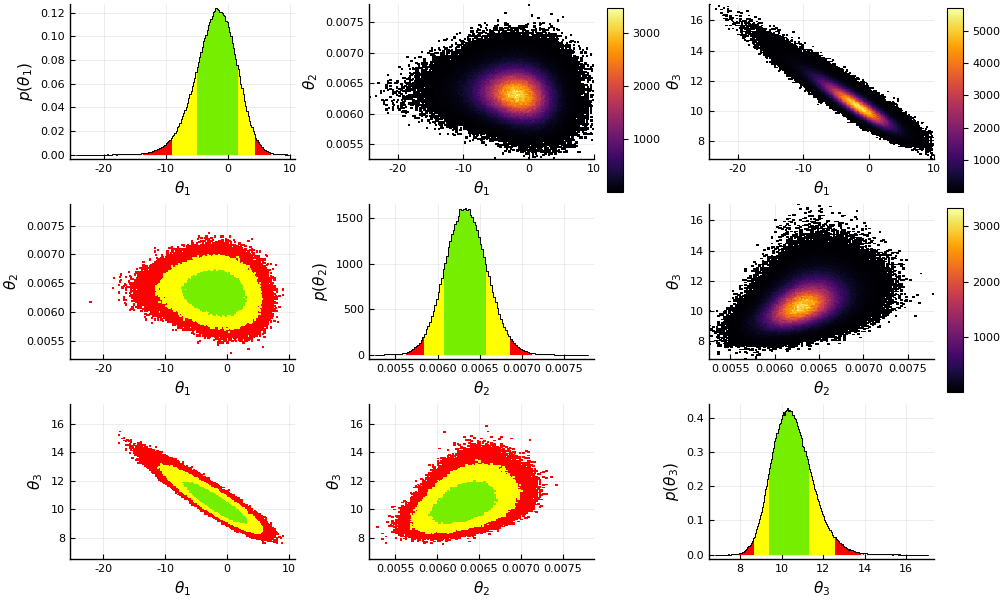

In [24]:
plot(samples_bm2, params=[1,2,3])

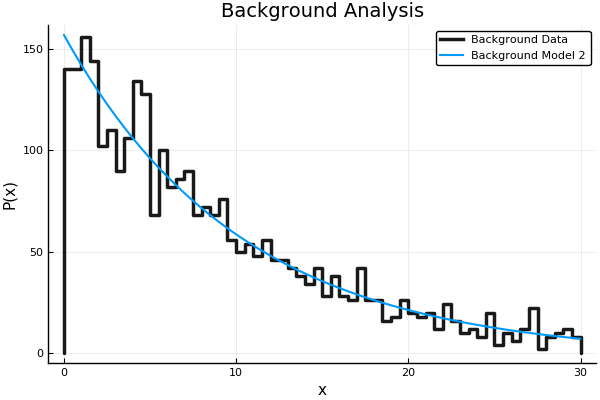

In [25]:
plot(normalize(hist_background, mode=:density),  seriestype = :steps, lw=2.5, alpha=0.9, color=:black, label="Background Data")
plot!(xlabel = "x", ylabel="P(x)", title="Background Analysis")

plot!(
    bins, x -> background_model_2(mode_parms_bm2, x),
    label = "Background Model 2", lw=1.5, color=1
)


In [26]:
data_bm2 = HMIData(samples_bm2)
        
hm_integrate!(data_bm2)

┌ Info: Harmonic Mean Integration started. Samples in dataset 1 / 2: 	560459 / 560459	Parameters:	3
└ @ BAT /home/iwsatlas1/vhafych/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:87
┌ Info: Data Whitening.
└ @ BAT /home/iwsatlas1/vhafych/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:100
┌ Info: Apply Whitening Transformation to Data Set 2
└ @ BAT /home/iwsatlas1/vhafych/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:109
┌ Info: Create Space Partitioning Tree
└ @ BAT /home/iwsatlas1/vhafych/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:121
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
┌ Info: Determine Hyperrectangle Starting Samples
└ @ BAT /home/iwsatlas1/vhafych/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:137
┌ Warning: Returned minimum number of starting points: 16
└ @ BAT /home/iwsatlas1/vhafych/gitrepos/BAT.jl/src/integration/ahmi/hyper_rectangle.jl:98
┌ Wa

Parameters: 3	Total Samples: 1120918
Data Set 1: 17 Volumes
Data Set 2: 19 Volumes

Integral Estimate (cov. weighted result):
	 3.6520099999999996e-79  +-  1.53008e-81

Integral Estimate (analytic result):
	 3.62623e-79  +-  2.00636e-81


## Comparison of background models: 

In [27]:
tot_vol_bm1 = data_bm1.integralestimates["analytic result"].final.estimate
tot_vol_bm2 = data_bm2.integralestimates["analytic result"].final.estimate;

In [28]:
@show tot_vol_bm2/tot_vol_bm1;

tot_vol_bm2 / tot_vol_bm1 = 650016.3883235909


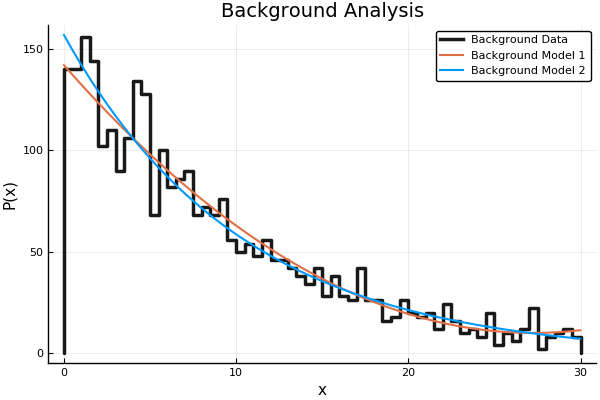

In [29]:
plot(normalize(hist_background, mode=:density),  seriestype = :steps, lw=2.5, alpha=0.9, color=:black, label="Background Data")
plot!(xlabel = "x", ylabel="P(x)", title="Background Analysis")

plot!(
    bins, x -> background_model_1(mode_parms_bm1, x),
    label = "Background Model 1", lw=1.5, color=2
)

plot!(
    bins, x -> background_model_2(mode_parms_bm2, x),
    label = "Background Model 2", lw=1.5, color=1
)


## Use background model #2 posterior as a prior: 

In [30]:
samples = hcat(samples_bm2.params...);

A_1 = Histogram(-25.0:0.5:10.0)
A_2 = Histogram(0.005:0.00005:0.0075)
A_3 = Histogram(5:0.3:17)

append!(A_1, samples[1,:])
append!(A_2, samples[2,:])
append!(A_3, samples[3,:])

Histogram{Int64,1,Tuple{StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}}}}
edges:
  5.0:0.3:17.0
weights: [0, 0, 0, 0, 0, 0, 6, 20, 139, 734  …  1126, 576, 298, 179, 82, 65, 36, 19, 8, 6]
closed: left
isdensity: false

## Signal and background: 

In [31]:
likelihood_signal = HistogramLikelihood(hist_signal, background_signal_model);

prior_signal = NamedPrior(
    A = [BAT.HistogramAsUvDistribution(A_1), BAT.HistogramAsUvDistribution(A_2), BAT.HistogramAsUvDistribution(A_3)],
    D = [0.0..200], 
    x_0 = [13 .. 17], 
    G = [0.0 .. 5.0]
);


parshapes_signal = VarShapes(prior_signal)
posterior_signal = PosteriorDensity(likelihood_signal, prior_signal);
chainspec_signal = MCMCSpec(algorithm, posterior_signal, rngseed);

┌ Warning: var will default to corrected=true in the future. Use corrected=false for previous behaviour.
│   caller = ip:0x0
└ @ Core :-1


In [32]:
samples_signal, sampleids_signal, stats_signal, chains_signal = rand(
    chainspec_signal,
    nsamples,
    nchains,
    tuner_config = tuner_config,
    convergence_test = convergence_test,
    init_strategy = init_strategy,
    burnin_strategy = burnin_strategy,
    max_nsteps = max_nsteps,
    max_time = Inf,
    granularity = 1
);

┌ Info: Trying to generate 8 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:160
┌ Info: Selected 8 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:269
┌ Info: Begin tuning of 8 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:52
┌ Info: MCMC Tuning cycle 1 finished, 8 chains, 0 tuned, 8 converged.
└ @ BAT /home/iwsatlas1/vhafych/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:84
┌ Info: MCMC Tuning cycle 2 finished, 8 chains, 8 tuned, 8 converged.
└ @ BAT /home/iwsatlas1/vhafych/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:84
┌ Info: MCMC tuning of 8 chains successful after 2 cycle(s).
└ @ BAT /home/iwsatlas1/vhafych/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:88


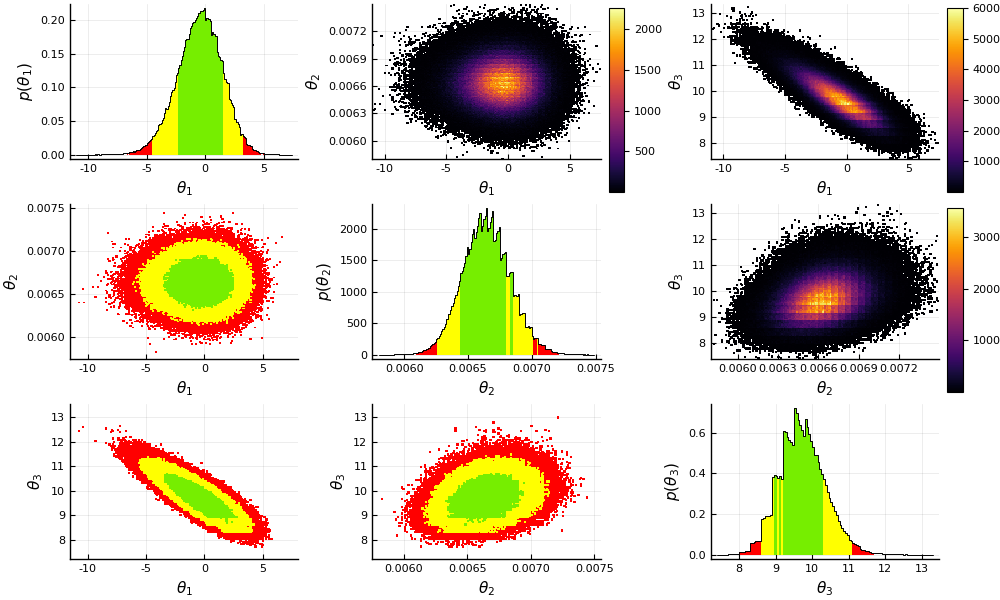

In [33]:
plot(samples_signal, params=[1,2,3])

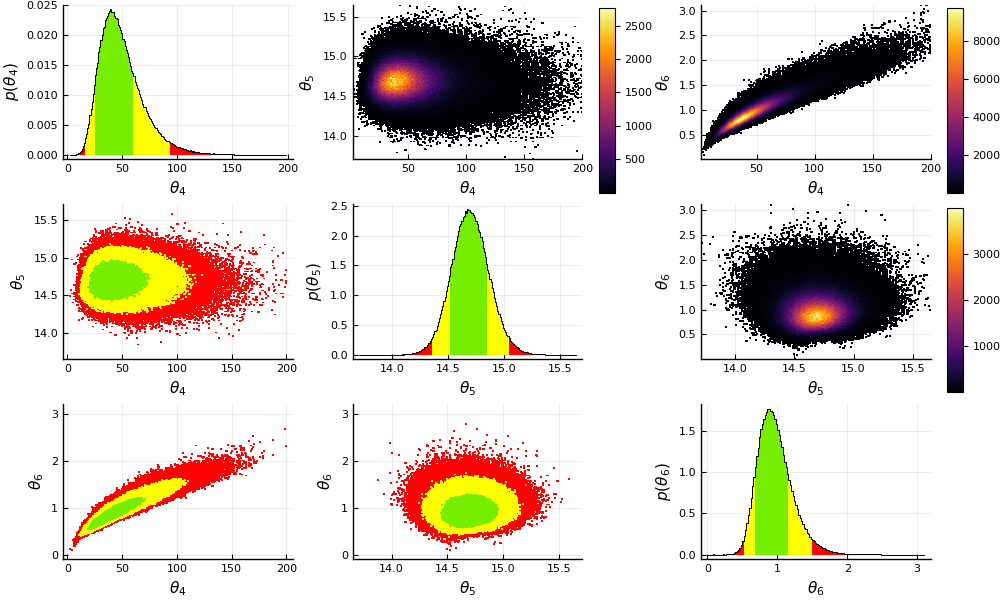

In [34]:
plot(samples_signal, params=[4,5,6])

In [35]:
mode_parms_signal = parshapes_signal(stats_signal.mode)

(A = [-0.035536589548095576, 0.006591164097853454, 9.508537216444868], D = [41.22639468793612], x_0 = [14.689965324916324], G = [0.859074567179892])

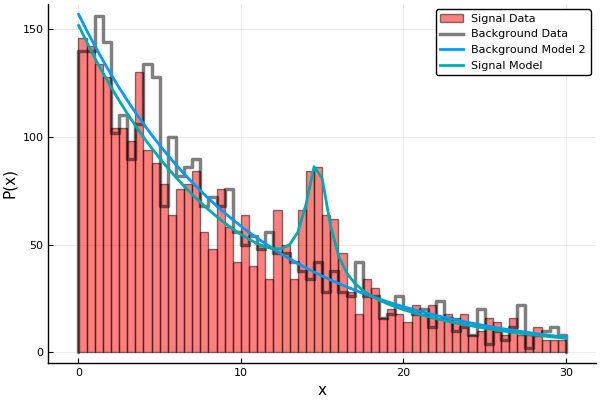

In [36]:
plot(normalize(hist_signal, mode=:density), alpha=0.5, color=:red, label="Signal Data")
plot!(normalize(hist_background, mode=:density),  seriestype = :steps, lw=2.5, alpha=0.5, color=:black, label="Background Data")
plot!(xlabel = "x", ylabel="P(x)")

plot!(
    bins, x -> background_model_2(mode_parms_bm2, x),
    label = "Background Model 2", lw=2, color=1
)

plot!(
    bins, x -> background_signal_model(mode_parms_signal, x),
    label = "Signal Model", lw=2, color=6
)



In [37]:
data_sig = HMIData(samples_signal)
        
hm_integrate!(data_sig)

┌ Info: Harmonic Mean Integration started. Samples in dataset 1 / 2: 	442575 / 442575	Parameters:	6
└ @ BAT /home/iwsatlas1/vhafych/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:87
┌ Info: Data Whitening.
└ @ BAT /home/iwsatlas1/vhafych/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:100
┌ Info: Apply Whitening Transformation to Data Set 2
└ @ BAT /home/iwsatlas1/vhafych/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:109
┌ Info: Create Space Partitioning Tree
└ @ BAT /home/iwsatlas1/vhafych/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:121
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
┌ Info: Determine Hyperrectangle Starting Samples
└ @ BAT /home/iwsatlas1/vhafych/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:137
┌ Info: Determine Tolerances for Hyperrectangle Creation
└ @ BAT /home/iwsatlas1/vhafych/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.j

Parameters: 6	Total Samples: 885150
Data Set 1: 52 Volumes
Data Set 2: 57 Volumes

Integral Estimate (cov. weighted result):
	 1.4948e-76  +-  8.71583e-79

Integral Estimate (analytic result):
	 1.49508e-76  +-  5.75918e-79


## Signal vs. no signal 

In [38]:
likelihood_nosignal = HistogramLikelihood(hist_signal, background_model_2);

prior_nosignal = NamedPrior(
    A = [-10.0 .. 10.0, -1.0 .. 1.0, 0.0 .. 30.0],
);


parshapes_nosignal = VarShapes(prior_nosignal)
posterior_nosignal = PosteriorDensity(likelihood_nosignal, prior_nosignal);
chainspec_nosignal = MCMCSpec(algorithm, posterior_nosignal, rngseed);

In [39]:
samples_nosignal, sampleids_nosignal, stats_nosignal, chains_nosignal = rand(
    chainspec_nosignal,
    nsamples,
    nchains,
    tuner_config = tuner_config,
    convergence_test = convergence_test,
    init_strategy = init_strategy,
    burnin_strategy = burnin_strategy,
    max_nsteps = max_nsteps,
    max_time = Inf,
    granularity = 1
);

┌ Info: Trying to generate 8 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:160
┌ Info: Selected 8 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:269
┌ Info: Begin tuning of 8 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:52
┌ Info: MCMC Tuning cycle 1 finished, 8 chains, 0 tuned, 0 converged.
└ @ BAT /home/iwsatlas1/vhafych/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:84
┌ Info: MCMC Tuning cycle 2 finished, 8 chains, 0 tuned, 0 converged.
└ @ BAT /home/iwsatlas1/vhafych/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:84
┌ Info: MCMC Tuning cycle 3 finished, 8 chains, 1 tuned, 0 converged.
└ @ BAT /home/iwsatlas1/vhafych/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:84
┌ Info: MCMC Tuning cycle 4 finished, 8 chains, 7 tuned, 0 converged.
└ @ BAT /home/iwsatlas1/vhafych/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:84
┌ Info: MCM

In [40]:
mode_parms_nosignal = parshapes_nosignal(stats_nosignal.mode)

(A = [-9.99967680793206, 0.006762506977802461, 13.686525493091244],)

In [ ]:
plot(normalize(hist_signal, mode=:density), alpha=0.5, color=:red, label="Signal Data")
plot!(xlabel = "x", ylabel="P(x)")

plot!(
    bins, x -> background_model_2(mode_parms_nosignal, x),
    label = "No signal assumption", lw=2, color=3
)

plot!(
    bins, x -> background_signal_model(mode_parms_signal, x),
    label = "Signal assumption", lw=2, color=6
)



In [42]:
data_nosign = HMIData(samples_nosignal)
        
hm_integrate!(data_nosign)

┌ Info: Harmonic Mean Integration started. Samples in dataset 1 / 2: 	608404 / 608404	Parameters:	3
└ @ BAT /home/iwsatlas1/vhafych/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:87
┌ Info: Data Whitening.
└ @ BAT /home/iwsatlas1/vhafych/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:100
┌ Info: Apply Whitening Transformation to Data Set 2
└ @ BAT /home/iwsatlas1/vhafych/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:109
┌ Info: Create Space Partitioning Tree
└ @ BAT /home/iwsatlas1/vhafych/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:121
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
┌ Info: Determine Hyperrectangle Starting Samples
└ @ BAT /home/iwsatlas1/vhafych/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:137
┌ Warning: Returned minimum number of starting points: 16
└ @ BAT /home/iwsatlas1/vhafych/gitrepos/BAT.jl/src/integration/ahmi/hyper_rectangle.jl:98
┌ Wa

Parameters: 3	Total Samples: 1216808
Data Set 1: 16 Volumes
Data Set 2: 16 Volumes

Integral Estimate (cov. weighted result):
	 3.15149e-91  +-  9.33195e-94

Integral Estimate (analytic result):
	 3.1883e-91  +-  1.24967e-93


In [43]:
post_signal = data_sig.integralestimates["analytic result"].final.estimate
post_nosign = data_nosign.integralestimates["analytic result"].final.estimate;

@show post_signal/post_nosign;

post_signal / post_nosign = 4.68926244899042e14
